In [1]:
import warnings

import matplotlib as mpl
from IPython import get_ipython

import pymor.tools.random

ip = get_ipython()
if ip is not None:
    ip.run_line_magic('matplotlib', 'inline')

warnings.filterwarnings('ignore', category=UserWarning, module='torch')

pymor.tools.random._default_random_state = None

mpl.rcParams['figure.facecolor'] = (1.0, 1.0, 1.0, 0.0)


Loading pyMOR defaults from file /builds/pymor/pymor/docs/source/pymor_defaults.py


# Available MOR methods

Here we give an overview over (most of) the available MOR methods implemented in pyMOR.
We provide short code snippets that show how to use these methods with pyMOR.
For more in-depth explanations we refer to the {doc}`tutorials`.

## Data approximation

### POD

In [2]:
# generate some data to approximate
from pymor.models.examples import thermal_block_example
fom = thermal_block_example(diameter=1/10)
U = fom.solution_space.empty()
for mu in fom.parameters.space(0.1, 1).sample_randomly(10):
    U.append(fom.solve(mu))

# return first 3 POD modes and singular values
from pymor.algorithms.pod import pod
modes, singular_values = pod(U, modes=3)

# return modes with singular value larger than 1e-3
modes, _  = pod(U, atol=1e-3)

# return right-singular vectors
modes, _, coeffs = pod(U, return_reduced_coefficients=True)

# use slower but more accurate algorithm
# (default algorithm is only accurate up to half machine precision)
modes, _ = pod(U, method='qr_svd')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

## Parametric MOR

Here we consider MOR methods for `Models` that depend on one or more `Parameters`.

### Reduced Basis method for parameter-separable, linear, coercive models

In [3]:
from pymor.models.examples import thermal_block_example
fom = thermal_block_example(diameter=1/10)

# FOM is parameter separable, i.e., system operator is a
# linear combination of non-parametric operators with parametric coefficients
print(repr(fom.operator))

# instantiate reductor that builds the ROM given some reduced basis;
# `product` is inner product w.r.t. which MOR error is estimated;
# `coercivity_estimator` needs to return lower bound for the operator's
# coercivity constant (w.r.t. given `product`) for the given parameter values
from pymor.parameters.functionals import ExpressionParameterFunctional
from pymor.reductors.coercive import CoerciveRBReductor
reductor = CoerciveRBReductor(
    fom,
    product=fom.h1_0_semi_product,
    coercivity_estimator=ExpressionParameterFunctional('min(diffusion)', fom.parameters)
)

# note: use SimpleCoerciveRBReductor for faster offline phase but error estimator that
# only is accurate up to half machine precision

# use weak greedy algorithm to train the model
from pymor.algorithms.greedy import rb_greedy
greedy_data = rb_greedy(fom, reductor,
                        fom.parameters.space(0.1, 1).sample_randomly(1000),  # training set
                        rtol=1e-2)
rom = greedy_data['rom']

# estimate and compute state-space MOR error
mu = rom.parameters.parse([0.1, 0.9, 0.2, 0.3])
u = rom.solve(mu)
print(f'Error estimate: {rom.estimate_error(mu)}')
print(f'Actual error: {(fom.solve(mu) - reductor.reconstruct(u)).norm(fom.h1_0_semi_product)}')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

LincombOperator(
    (NumpyMatrixOperator(<221x221 sparse, 40 nnz>, source_id='STATE', range_id='STATE', name='boundary_part'),
     NumpyMatrixOperator(<221x221 sparse, 231 nnz>, source_id='STATE', range_id='STATE', name='diffusion_0'),
     NumpyMatrixOperator(<221x221 sparse, 231 nnz>, source_id='STATE', range_id='STATE', name='diffusion_1'),
     NumpyMatrixOperator(<221x221 sparse, 231 nnz>, source_id='STATE', range_id='STATE', name='diffusion_2'),
     NumpyMatrixOperator(<221x221 sparse, 231 nnz>, source_id='STATE', range_id='STATE', name='diffusion_3')),
    (1.0,
     ProjectionParameterFunctional('diffusion', size=4, index=0, name='diffusion_0_0'),
     ProjectionParameterFunctional('diffusion', size=4, index=1, name='diffusion_1_0'),
     ProjectionParameterFunctional('diffusion', size=4, index=2, name='diffusion_0_1'),
     ProjectionParameterFunctional('diffusion', size=4, index=3, name='diffusion_1_1')),
    name='ellipticOperator')


Error estimate: [0.00313244]
Actual error: [0.00138708]


### POD-Greedy method for parabolic models

In [4]:
from pymor.models.examples import heat_equation_example
fom = heat_equation_example()
parameter_space = fom.parameters.space(1, 100)

from pymor.parameters.functionals import ExpressionParameterFunctional
coercivity_estimator = ExpressionParameterFunctional('1.', fom.parameters)
from pymor.reductors.parabolic import ParabolicRBReductor
reductor = ParabolicRBReductor(fom, product=fom.h1_0_semi_product, coercivity_estimator=coercivity_estimator)

from pymor.algorithms.greedy import rb_greedy
training_set = parameter_space.sample_uniformly(20)
greedy_data = rb_greedy(fom, reductor, training_set=parameter_space.sample_uniformly(20), max_extensions=10)
rom = greedy_data['rom']

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

### Estimation of coercivity and continuity constants using the min/max-theta approach

In [5]:
from pymor.models.examples import thermal_block_example
fom = thermal_block_example(diameter=1/10)

from pymor.parameters.functionals import ExpressionParameterFunctional
mu = fom.parameters.parse([0.1, 0.9, 0.2, 0.3])
exact_coercivity_estimator = ExpressionParameterFunctional('min(diffusion)', fom.parameters)

from pymor.parameters.functionals import MaxThetaParameterFunctional, MinThetaParameterFunctional
mu_bar = fom.parameters.parse([0.5, 0.5, 0.5, 0.5])
coercivity_estimator = MinThetaParameterFunctional(fom.operator.coefficients, mu_bar, alpha_mu_bar=0.5)
continuity_estimator = MaxThetaParameterFunctional(fom.operator.coefficients, mu_bar, gamma_mu_bar=0.5)

print(f"Exact coercivity constant estimate: {exact_coercivity_estimator.evaluate(mu)}")
print(f"Coercivity constant estimate using min-theta approach: {coercivity_estimator.evaluate(mu)}")
print(f"Continuity constant estimate using max-theta approach: {continuity_estimator.evaluate(mu)}")

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

Exact coercivity constant estimate: 0.1
Coercivity constant estimate using min-theta approach: 0.1
Continuity constant estimate using max-theta approach: 0.9


### Estimation of coercivity constants using the successive constraints method

In [6]:
from pymor.models.examples import thermal_block_example
fom = thermal_block_example(diameter=0.1)
parameter_space = fom.parameters.space(0.1, 1.)

from pymor.algorithms.scm import construct_scm_functionals
initial_parameter = parameter_space.sample_randomly(1)[0]
training_set = parameter_space.sample_randomly(50)
coercivity_estimator, _, _ = construct_scm_functionals(
    fom.operator, training_set, initial_parameter, product=fom.h1_0_semi_product, max_extensions=10, M=5)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

/builds/pymor/pymor/src/pymor/algorithms/eigs.py:152: RuntimeWarning: invalid value encountered in divide
  ew.imag[np.abs(ew.imag) / np.abs(ew) < imag_tol] = 0
/builds/pymor/pymor/src/pymor/algorithms/eigs.py:158: RuntimeWarning: divide by zero encountered in divide
  rres = f.norm()[0] * np.abs(evs[-1]) / np.abs(ews)
/builds/pymor/pymor/src/pymor/algorithms/eigs.py:158: RuntimeWarning: invalid value encountered in divide
  rres = f.norm()[0] * np.abs(evs[-1]) / np.abs(ews)


/builds/pymor/pymor/src/pymor/bindings/scipy.py:242: ComplexWarning: Casting complex values to real discards the imaginary part
  R = matrix.factorization.solve(V.T).T.astype(promoted_type, copy=False)


### POD/neural network approximation

In [7]:
from pymor.models.examples import thermal_block_example
fom = thermal_block_example(diameter=1/10)

# instantiate reductor with training and validation parameters and desired errors
from pymor.reductors.neural_network import NeuralNetworkReductor
reductor = NeuralNetworkReductor(fom,
                                 training_set=fom.parameters.space(0.1, 1).sample_uniformly(2),
                                 validation_set=fom.parameters.space(0.1, 1).sample_randomly(5),
                                 ann_mse=None, scale_outputs=True)
rom = reductor.reduce(restarts=5)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

### Empirical interpolation of coefficient functions

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

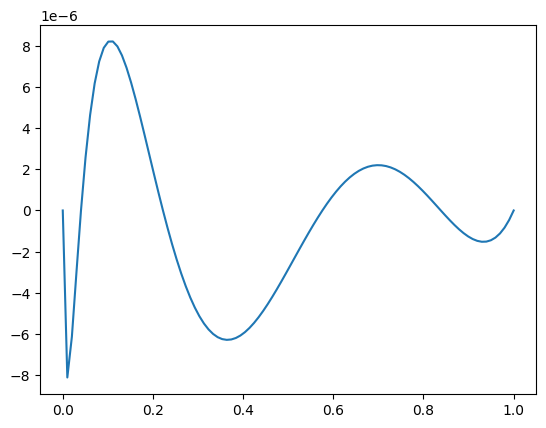

In [8]:
from matplotlib import pyplot as plt
import numpy as np
from pymor.algorithms.ei import interpolate_function
from pymor.analyticalproblems.functions import ExpressionFunction

f = ExpressionFunction('1 + x[0]**exp[0]', 1, {'exp': 1})
parameter_space = f.parameters.space(1, 3)
f_ei, _ = interpolate_function(
    f, parameter_space.sample_uniformly(10), np.linspace(0, 1, 100).reshape((-1,1)), rtol=1e-4)

mu = f.parameters.parse(2.3)
X = np.linspace(0, 1, 100)
plt.plot(X, f(X.reshape((-1,1)), mu=mu) - f_ei(X.reshape((-1,1)), mu=mu))
plt.show()

### EI-Greedy/POD-Greedy reduction of nonlinear models

In [9]:
from pymor.algorithms.ei import interpolate_operators
from pymor.algorithms.greedy import rb_greedy
from pymor.analyticalproblems.burgers import burgers_problem_2d
from pymor.discretizers.builtin.fv import discretize_instationary_fv
from pymor.reductors.basic import InstationaryRBReductor

problem = burgers_problem_2d()
fom, _ = discretize_instationary_fv(problem, diameter=1./20, num_flux='engquist_osher', nt=100)
fom.enable_caching('disk')  # cache solution snapshots on disk

training_set = problem.parameter_space.sample_uniformly(10)
fom_ei, _ = interpolate_operators(
    fom, ['operator'], training_set, error_norm=fom.l2_norm, max_interpolation_dofs=30)
reductor = InstationaryRBReductor(fom_ei)
greedy_data = rb_greedy(
    fom, reductor, training_set, use_error_estimator=False, max_extensions=10)
rom = greedy_data['rom']

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

## LTI System MOR

Here we consider some of the methods for `LTIModels`.

### Balancing-based MOR

In [10]:
from pymor.models.examples import penzl_example
fom = penzl_example()

from pymor.reductors.bt import BTReductor
rom_bt = BTReductor(fom).reduce(10)

from pymor.reductors.bt import LQGBTReductor
rom_lqgbt = LQGBTReductor(fom).reduce(10)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

### Interpolation-based MOR

In [11]:
from pymor.models.examples import penzl_example
fom = penzl_example()

from pymor.reductors.h2 import IRKAReductor
rom_irka = IRKAReductor(fom).reduce(10)

from pymor.reductors.h2 import TFIRKAReductor
rom_irka = TFIRKAReductor(fom).reduce(10)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

### Eigenvalue-based MOR

In [12]:
from pymor.models.examples import penzl_example
fom = penzl_example()

from pymor.reductors.mt import MTReductor
rom_mt = MTReductor(fom).reduce(10)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

### Data-driven MOR

In [13]:
from pymor.models.examples import penzl_example
import numpy as np
fom = penzl_example()
s = np.logspace(1, 3, 100) * 1j

from pymor.reductors.aaa import PAAAReductor
rom_aaa = PAAAReductor(s, fom).reduce()

from pymor.reductors.loewner import LoewnerReductor
rom_loewner = LoewnerReductor(s, fom).reduce()

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

Download the code:
{download}`mor_methods.md`,
{nb-download}`mor_methods.ipynb`.